## **DS 5110: Big Data Systems | Final Project**
## **State of Virginia Traffic Reliability | MAP21**
## **Code Parts 2 & 3 | Data Splitting and Exploratory Data Analysis**

### by Christian Schroeder (dbn5eu), Timothy Tyree (twt6xy), Colin Warner (ynq9ya)

### Brief Overview

**Project Description:** The goal of our project is to create a model that predicts the reliability of traffic projections for segments of Virginia highways. Are there segments of highways that are highly variable in their traffic patterns and are therefore unreliable in their projected travel times? MAP21 is a bill that the state of Virginia is attempting to pass in order to fund improvements to unreliable highway segments. We hope our model would be able to inform state representatives of the segments that most need development. 


**Notebook Description:** In this particular notebook, we will begin by splitting our data into both a training and test data set. We will then perform Exploratory Data Analysis on our training set in order to understand the data we are working with and inform potential modelling decisions.    

### **Import Packages, Initialize Spark Session**

Below we import the necessary pyspark packages to perform our data import and preprocessing. We also create a Spark Session and establish a Spark SQL Context.

In [17]:
# importing
import functools, os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# establish Spark Context
spark = SparkSession.builder.getOrCreate()
sc = SQLContext(spark)

### **Import Data from Part 1 Notebook**

In [18]:
# get current working directory
os.getcwd()

'/sfs/qumulo/qhome/ynq9ya/ds5110/Project'

In [19]:
# define the file that we want to import from part 1 notebook.
data_long_file = 'data_long.csv'

Below we import the data_long.csv file into an object called data_long using spark.read.csv. We use the type() function to confirm that this is read in as a PySpark Dataframe, as opposed to another object type like an RDD. 

In [20]:
# read in file that was defined above.
data_long = spark.read.csv(data_long_file, header=True)
# confirm the object type of the file we read in. 
type(data_long)

pyspark.sql.dataframe.DataFrame

The count() function is used on our Dataframe to get a quick count of rows on our full data set prior to splitting. 

In [21]:
data_long.count()

27312

### **Data Splitting into Training and Test Sets**

#### Split 60/40

In [22]:
# Split the data into training and test sets (40% held out for testing). 
# Set seed as second argument to randomsplit function.
(training, test) = data_long.randomSplit([0.6, 0.4], 314)

#### Print Counts and Percentage of Each Data Set

In [23]:
# count records in datasets
(training.count(), test.count(), data_long.count())

(16273, 11039, 27312)

In [24]:
# percentage of records in datasets
(training.count()/data_long.count(), test.count()/data_long.count(), data_long.count()/data_long.count())

(0.5958186877562976, 0.4041813122437024, 1.0)

#### Save Test Set as CSV

We will now set aside our test data as a CSV in order to focus on EDA and modeling with our training data. We will revisit our test data in future coding notebooks. In order to use the to_csv() function, we must first convert the test Pyspark dataframe into a pandas dataframe. 

In [25]:
# convert Pyspark DF to Pandas DF
test = test.toPandas()
# Save test DF as CSV
test.to_csv("test.csv")

### **Exploratory Data Analysis**

In [26]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#### Convert to Pandas, Print First Five Rows

Since PySpark does not have much in the way of data visualization, we will convert our training data to Pandas for our Exploratory Data Analysis. 

In [27]:
df = training.toPandas()
df.head()

,_c0,year,tmc,EPDOR,LIIR,SSP,Hour_TMS_Vol,TMS_Vol,Lane_TMS_Vol,Hour_Lane_TMS_Vol,...,NPMRDS_weighted_VoverC,TMS_weighted_VoverC,Truck,Period,obs_rel_unrel,lanes,miles,Rolling,Urbanized,UrbanZCluster
0,0,2017,110+04872,19.63565634,3.813536562,Y,29.2991477,117.1965908,58.5982954,14.64957385,...,0.686666554,0.685238788,4.2172235,AMP,Unrel,2,0.625677,0,1,0
1,1,2017,110+04872,21.58299416,9.980106321,Y,25.78331757,154.6999054,77.3499527,12.89165878,...,0.605835062,0.604575366,4.4685001,MIDD,Unrel,2,0.625677,0,1,0
2,10,2017,110-05372,9.704800061,0.892395408,Y,19.54616164,78.18464655,39.09232328,9.773080819,...,0.601840434,0.627042663,20.1807726,PMP,Rel,2,1.563531,1,0,0
3,1000,2019,110+04870,19.43267126,3.913524073,Y,26.89155575,107.566223,35.85540767,8.963851917,...,0.728797359,0.418390129,4.2267249,AMP,Rel,3,0.022567,0,1,0
4,10001,2017,110N04956,0.214307834,0.428615668,N,21.91925357,131.5155214,43.83850713,7.306417856,...,0.323381435,0.359949984,8.8856418,MIDD,Rel,3,0.476666,0,1,0


#### Print number of rows and columns

In [28]:
print("Number of rows: " + str(df.shape[0])) 
print("Number of columns: " + str(df.shape[1]))

Number of rows: 16273
Number of columns: 25


#### Statistical Summary of Potential Predictor Variables

Our data set has 25 total columns. The column 'obs_rel_unrel' is our response variable, which indicates whether the traffic projections for that particular highway segment ('tmc') were reliable for a given year ('year') during a given daily traffic period ('period').

Below we've printed out a list of our 25 column names. We will then proceed by providing a statistical summary of several potential predictor variables. 

In [29]:
for col in df.columns:
    print(col)

_c0
year
tmc
EPDOR
LIIR
SSP
Hour_TMS_Vol
TMS_Vol
Lane_TMS_Vol
Hour_Lane_TMS_Vol
Hour_NPMRDS_Vol
NPMRDS_Vol
Hour_Lane_NPMRDS_Vol
NPMRDS_straight_VoverC
TMS_straight_VoverC
NPMRDS_weighted_VoverC
TMS_weighted_VoverC
Truck
Period
obs_rel_unrel
lanes
miles
Rolling
Urbanized
UrbanZCluster


**Which years are we working with?**

In [30]:
print("Our training set contains a range of observations between the years " + str(df['year'].min()) + " and " + str(df['year'].max())) 

Our training set contains a range of observations between the years 2017 and 2020


**How has overall reliability of highway segments changed from 2017 through 2020?**

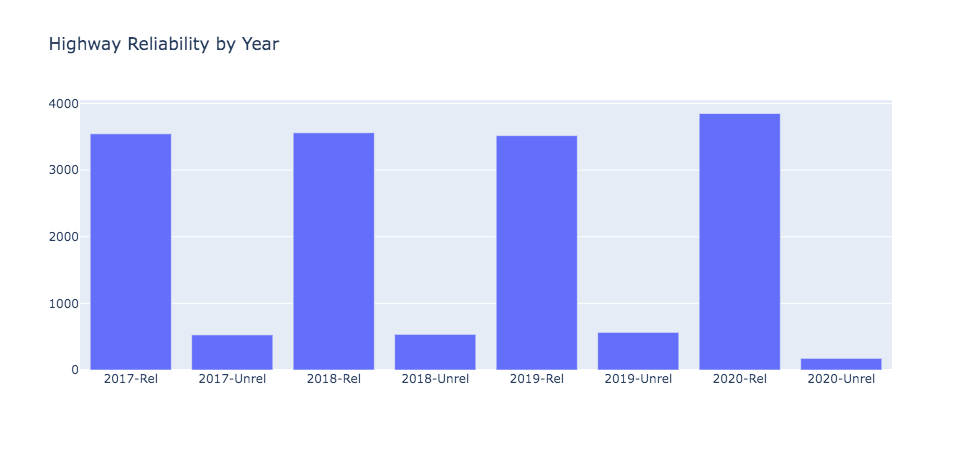

In [43]:
import plotly.graph_objects as go

df_year = df.groupby(['year','obs_rel_unrel'])['tmc'].count().reset_index()
df_year = df_year.rename(columns={'tmc': 'count_rec'})
df_year['group'] = df_year['year'] + "-" + df_year['obs_rel_unrel']

fig = go.Figure(
    data=[go.Bar(x=df_year.group,y=df_year.count_rec)],
    layout_title_text="Highway Reliability by Year"
)

fig.show()

**How does reliability differ between daily traffic windows?**

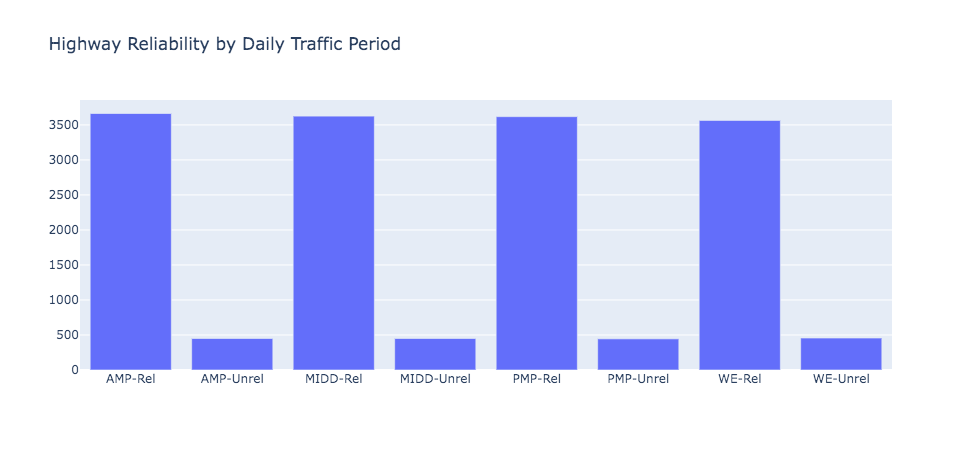

In [47]:
df_period = df.groupby(['Period','obs_rel_unrel'])['tmc'].count().reset_index()
df_period = df_period.rename(columns={'tmc': 'count_rec'})
df_period['group'] = df_period['Period'] + "-" + df_period['obs_rel_unrel']

fig2 = go.Figure(
    data=[go.Bar(x=df_period.group,y=df_period.count_rec)],
    layout_title_text="Highway Reliability by Daily Traffic Period"
)

fig2.show()

#### How long are the highway segments?

We look into the distribution of highway distances using our 'miles' variable. 

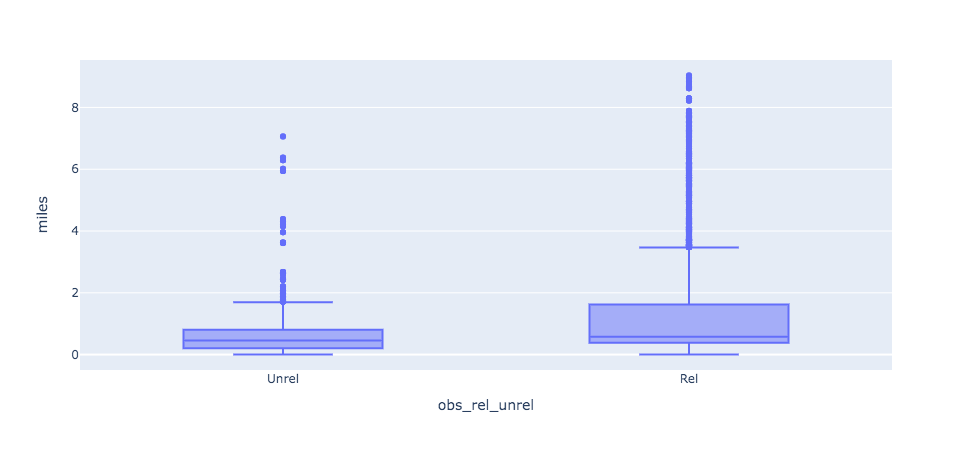

In [53]:
import plotly.express as px
import pandas as pd

df['miles'] = pd.to_numeric(df['miles'])

fig3 = px.box(df, x="obs_rel_unrel", y="miles")
 
fig3.show()
